In [1]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

We want to verify that the 2-d distribution of individual x-coordinates over time, $u(x, t)$, satisfies the porous medium equation:

$$\frac{d}{dt} u(x,t) = \frac{\sigma^2}{2}\frac{d^2}{dx^2}(u(x,t)^2) + u(x, t)(1-u(x,t))$$

Strategy:

1. Use Gaussian kernel density estimation to estimate $u(x, t)$ from the simulated locations
2. Calculate discrete approximations of $\frac{d}{dt} \widehat{u(x,t)}$ and  $\frac{d^2}{dx^2} \left(\widehat{u(x,t)}^2 \right)$

## Simulation

In [2]:
#! slim -d 'OUTPATH="pme_test.trees"' -d WIDTH=20 -d HEIGHT=2 -d NUMGENS=10 -d DISPERSAL_SIGMA=0.2 -d SIGMA=0.2 pme.slim  >/dev/null
ts = pyslim.load("pme.trees")

In [3]:
max_x = round(max(ts.individual_locations[:,0]))
max_y = round(max(ts.individual_locations[:,1]))
max_t = max(ts.individual_times)

print(max_x, max_y, max_t)

20 5 9999.0


## Use Gaussian KDE to estimate $u(x, t)$

In [4]:
locations = ts.individual_locations
times = ts.individual_times
dataset = [locations[:,0], times]
print(np.shape(dataset))
uhat = stats.gaussian_kde(dataset)

(2, 899785)


## Discrete derivatives

$\frac{d}{dt} \widehat{u(x,t)} \approx \frac{\widehat{u(x, t + h)} - \widehat{u(x, t)}}{h}$

$\frac{d}{dx} \widehat{u(x,t)} \approx \frac{\widehat{u(x + h, t)} - \widehat{u(x, t)}}{h}$

$\frac{d^2}{dx^2} \widehat{u(x,t)} \approx \frac{\widehat{\frac{d}{dx}u(x + h, t)} - \widehat{\frac{d}{dx}u(x, t)}}{h} = \frac{\frac{\widehat{u(x + 2h, t)} - \widehat{u(x + h, t)}}{h} - \frac{\widehat{u(x + h, t)} - \widehat{u(x, t)}}{h}}{h} = \frac{\widehat{u(x + 2h, t)} - 2\widehat{u(x + h, t)} + \widehat{u(x, t)}}{h^2}$

In [5]:
h1 = 1e-3
h2 = 1e-6
sigma = 0.2

x_bins = np.arange(0, max_x, 2)
y_bins = np.arange(0, max_y, 2)
time_bins = np.arange(0, 10, 2)

x_vals = []
y_vals = []
t_vals = []
ddt1_vals = []
ddt2_vals = []
ddx1_vals = []
ddx2_vals = []
d2dx21_vals = []
d2dx22_vals = []
lhs = []
rhs = []

for x in x_bins:
    for y in y_bins:
        for t in time_bins:
            
            x_vals.append(x)
            y_vals.append(y)
            t_vals.append(t)
            
            ddt1 = (uhat.evaluate([x, t + h1]) - uhat.evaluate([x, t]))/h1
            ddt2 = (uhat.evaluate([x, t + h2]) - uhat.evaluate([x, t]))/h2

            ddt1_vals = np.concatenate([ddt1_vals, ddt1])
            ddt2_vals = np.concatenate([ddt2_vals, ddt2])
            #print(ddt1, ddt2)

            ddx1 = (uhat.evaluate([x + h1, t]) - uhat.evaluate([x, t]))/h1
            ddx2 = (uhat.evaluate([x + h2, t]) - uhat.evaluate([x, t]))/h2

            ddx1_vals = np.concatenate([ddx1_vals, ddx1])
            ddx2_vals = np.concatenate([ddx2_vals, ddx2])            
            #print(ddx1, ddx2)

            d2dx21 = (uhat.evaluate([x + 2*h1, t]) - 2*uhat.evaluate([x + h1, t]) + uhat.evaluate([x, t]))/h1**2
            d2dx22 = (uhat.evaluate([x + 2*h2, t]) - 2*uhat.evaluate([x + h2, t]) + uhat.evaluate([x, t]))/h2**2
            
            d2dx21_vals = np.concatenate([d2dx21_vals, d2dx21])
            d2dx22_vals = np.concatenate([d2dx22_vals, d2dx22])
            #print(d2dx21, d2dx22)

            uxt = uhat.evaluate([x, t])

            lhs = np.concatenate([lhs, ddt1])
            rhs = np.concatenate([rhs, ((sigma**2/2)*d2dx21 + uxt*(1 - uxt))])

#print(lhs)
#print(rhs)

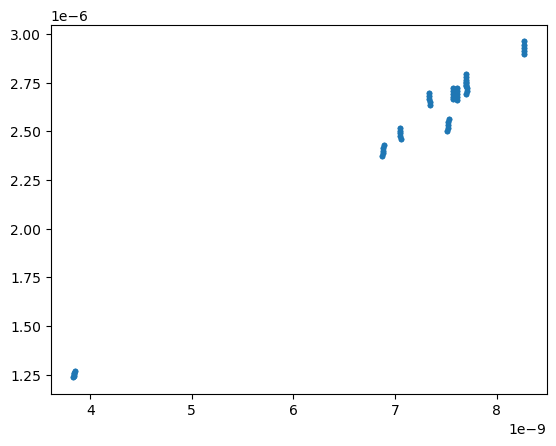

In [6]:
fig, ax = plt.subplots()
ax.plot(lhs, rhs, '.')
plt.show()

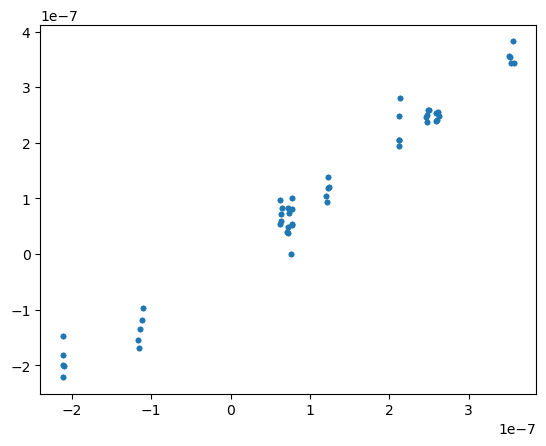

In [7]:
fig, ax = plt.subplots()
ax.plot(d2dx21_vals, d2dx22_vals, '.')
plt.show()


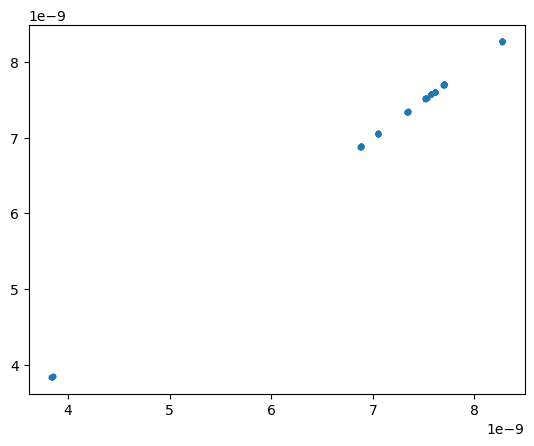

In [8]:
fig, ax = plt.subplots()
ax.plot(ddt1_vals, ddt2_vals, '.')
plt.show()
